Dataset shape: (9240, 180)
Training set: 7392 samples
Test set: 1848 samples
Features: 179
Target distribution: {0: 5679, 1: 3561}
Starting comprehensive analysis...
Starting model training with hyperparameter tuning...

Training Random Forest...
Best CV Score: 0.9804 (+/- 0.0024)
Training Time: 108.77 seconds
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}

Training LightGBM...
Best CV Score: 0.9843 (+/- 0.0026)
Training Time: 28.87 seconds
Best Parameters: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Training XGBoost...
Best CV Score: 0.9844 (+/- 0.0021)
Training Time: 25.07 seconds
Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Training CatBoost...
Best CV Score: 0.9846 (+/- 0.0037)
Training Time: 40.03 seconds
Best Paramete

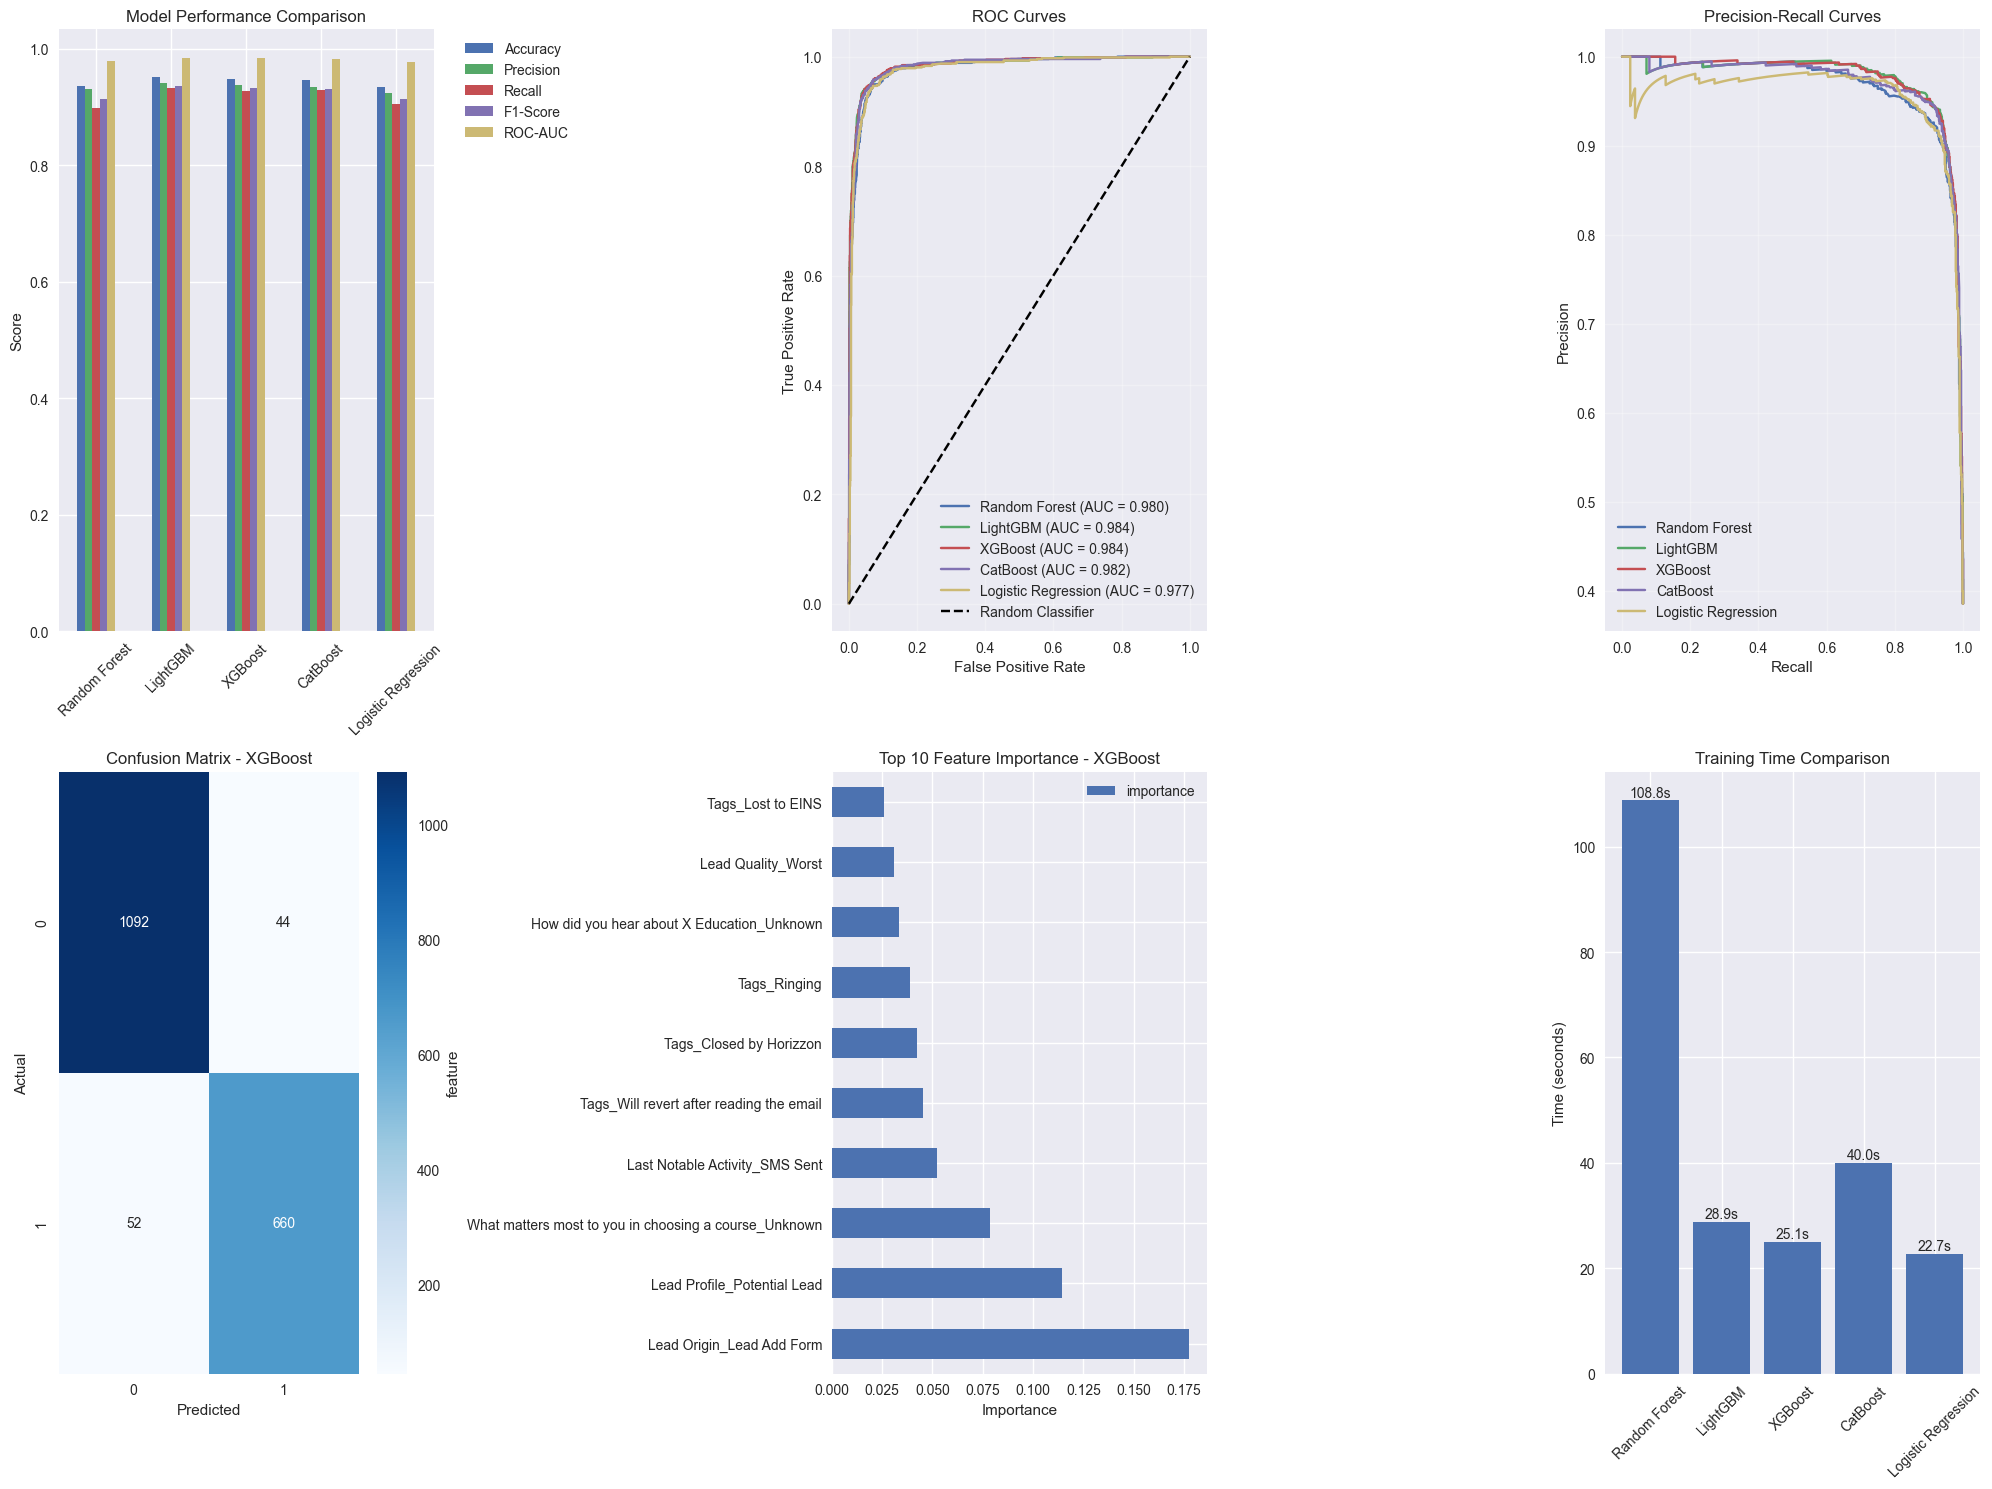


Visualization saved to: plots\model_analysis.png

COMPREHENSIVE MODEL ANALYSIS & INSIGHTS

🏆 BEST MODEL: XGBoost
   • ROC-AUC Score: 0.9840
   • Accuracy: 0.9481
   • Precision: 0.9375
   • Recall: 0.9270
   • F1-Score: 0.9322
   • Training Time: 25.07 seconds

📊 MODEL RANKING (by ROC-AUC):
   1. XGBoost: 0.9840
   2. LightGBM: 0.9836
   3. CatBoost: 0.9823
   4. Random Forest: 0.9796
   5. Logistic Regression: 0.9775

🎯 PERFORMANCE INSIGHTS:
   • Model Performance: Excellent discrimination ability (AUC = 0.9840)
   • Model Focus: Higher precision (0.9375) vs recall (0.9270) - fewer false positives

🔍 TOP 5 MOST IMPORTANT FEATURES:
   1. Lead Origin_Lead Add Form: 0.1774
   2. Lead Profile_Potential Lead: 0.1144
   3. What matters most to you in choosing a course_Unknown: 0.0787
   4. Last Notable Activity_SMS Sent: 0.0522
   5. Tags_Will revert after reading the email: 0.0455

⚖️ MODEL COMPLEXITY ANALYSIS:
   • Fastest Training: Logistic Regression (22.71s)
   • Slowest Training: Ran

In [17]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

# ML: Models, training, and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

class EnhancedSalesConversionPredictor:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {}
        self.best_model = None
        self.best_model_name = None
        self.results = {}
        self.is_fitted = False
        self.model_dir = "model"
        os.makedirs(self.model_dir, exist_ok=True)
        
        # Create plots directory
        self.plots_dir = "plots"
        os.makedirs(self.plots_dir, exist_ok=True)
        
        self.model_configs = {
            'Random Forest': {
                'model': RandomForestClassifier(random_state=self.random_state, n_jobs=-1),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [10, 20, None],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'max_features': ['sqrt', 'log2', None]
                }
            },
            'LightGBM': {
                'model': lgb.LGBMClassifier(random_state=self.random_state, n_jobs=-1, verbose=-1),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [6, 10, 15],
                    'learning_rate': [0.01, 0.1, 0.2],
                    'num_leaves': [31, 50, 100],
                    'subsample': [0.8, 0.9, 1.0],
                    'colsample_bytree': [0.8, 0.9, 1.0]
                }
            },
            'XGBoost': {
                'model': xgb.XGBClassifier(random_state=self.random_state, n_jobs=-1, eval_metric='logloss'),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [3, 6, 10],
                    'learning_rate': [0.01, 0.1, 0.2],
                    'subsample': [0.8, 0.9, 1.0],
                    'colsample_bytree': [0.8, 0.9, 1.0],
                    'reg_alpha': [0, 0.1, 1],
                    'reg_lambda': [0, 0.1, 1]
                }
            },
            'CatBoost': {
                'model': CatBoostClassifier(random_state=self.random_state, verbose=False, thread_count=-1),
                'params': {
                    'iterations': [100, 200, 300],
                    'depth': [4, 6, 8],
                    'learning_rate': [0.01, 0.1, 0.2],
                    'l2_leaf_reg': [1, 3, 5],
                    'border_count': [32, 64, 128]
                }
            },
            'Logistic Regression': {
                'model': LogisticRegression(random_state=self.random_state, max_iter=1000),
                'params': {
                    'C': [0.1, 1, 10],
                    'penalty': ['l1', 'l2'],
                    'solver': ['liblinear', 'saga']
                }
            }
        }

    def load_and_prepare_data(self, data_path=None, df=None, target_column='Converted'):
        """Load and prepare data for training"""
        if df is not None:
            self.df = df.copy()
        elif data_path is not None:
            self.df = pd.read_csv(data_path)
        else:
            raise ValueError("Either data_path or df must be provided")
        
        if target_column not in self.df.columns:
            raise ValueError(f"Target column '{target_column}' not found in the dataset")
        
        # Separate features and target
        self.X = self.df.drop(target_column, axis=1)
        self.y = self.df[target_column]
        self.feature_names = self.X.columns.tolist()
        
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=self.random_state, stratify=self.y
        )
        
        print(f"Dataset shape: {self.df.shape}")
        print(f"Training set: {self.X_train.shape[0]} samples")
        print(f"Test set: {self.X_test.shape[0]} samples")
        print(f"Features: {self.X.shape[1]}")
        print(f"Target distribution: {self.y.value_counts().to_dict()}")
        
        return self

    def train_models(self, cv_folds=5, scoring='roc_auc', n_jobs=-1, max_evals=20):
        """Train multiple models with hyperparameter tuning"""
        print("Starting model training with hyperparameter tuning...")
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
        
        for name, config in self.model_configs.items():
            print(f"\nTraining {name}...")
            start_time = datetime.now()
            
            model = config['model']
            param_grid = config['params']
            
            # Use RandomizedSearchCV for large parameter spaces, GridSearchCV for smaller ones
            search = RandomizedSearchCV(
                model, param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs, 
                n_iter=max_evals, random_state=self.random_state
            ) if len(param_grid) > 3 else GridSearchCV(
                model, param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs
            )
            
            search.fit(self.X_train, self.y_train)
            self.models[name] = search.best_estimator_
            
            training_time = (datetime.now() - start_time).total_seconds()
            
            self.results[name] = {
                'best_params': search.best_params_,
                'best_cv_score': search.best_score_,
                'cv_std': search.cv_results_['std_test_score'][search.best_index_],
                'training_time': training_time,
                'model': search.best_estimator_
            }
            
            print(f"Best CV Score: {search.best_score_:.4f} (+/- {search.cv_results_['std_test_score'][search.best_index_]:.4f})")
            print(f"Training Time: {training_time:.2f} seconds")
            print(f"Best Parameters: {search.best_params_}")
        
        self.is_fitted = True
        print("\nAll models trained successfully!")
        return self

    def evaluate_models(self):
        """Evaluate all trained models"""
        if not self.is_fitted:
            raise ValueError("Models must be trained first!")
        
        print("\nEvaluating models on test set...")
        evaluation_results = {}
        
        for name, model in self.models.items():
            y_pred = model.predict(self.X_test)
            y_pred_proba = model.predict_proba(self.X_test)[:, 1]
            
            metrics = {
                'Accuracy': accuracy_score(self.y_test, y_pred),
                'Precision': precision_score(self.y_test, y_pred),
                'Recall': recall_score(self.y_test, y_pred),
                'F1-Score': f1_score(self.y_test, y_pred),
                'ROC-AUC': roc_auc_score(self.y_test, y_pred_proba),
                'CV_Score': self.results[name]['best_cv_score'],
                'Training_Time': self.results[name]['training_time']
            }
            
            evaluation_results[name] = metrics
            
            # Store predictions and probabilities
            self.results[name]['test_predictions'] = y_pred
            self.results[name]['test_probabilities'] = y_pred_proba
            self.results[name]['test_metrics'] = metrics
        
        # Create results DataFrame and identify best model
        results_df = pd.DataFrame(evaluation_results).T.sort_values('ROC-AUC', ascending=False)
        self.best_model_name = results_df.index[0]
        self.best_model = self.models[self.best_model_name]
        
        print("\nModel Performance Comparison:")
        print(results_df.round(4))
        print(f"\nBest Model: {self.best_model_name}")
        print(f"Best ROC-AUC Score: {results_df.loc[self.best_model_name, 'ROC-AUC']:.4f}")
        
        return results_df

    def save_best_model(self):
        """Save the best model as a pickle file"""
        if self.best_model is None:
            raise ValueError("No best model found. Please run evaluate_models() first.")
        
        # Create model metadata
        model_metadata = {
            'model_name': self.best_model_name,
            'model': self.best_model,
            'feature_names': self.feature_names,
            'best_params': self.results[self.best_model_name]['best_params'],
            'test_metrics': self.results[self.best_model_name]['test_metrics'],
            'cv_score': self.results[self.best_model_name]['best_cv_score'],
            'training_time': self.results[self.best_model_name]['training_time'],
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        
        # Save model
        model_path = os.path.join(self.model_dir, f'best_model_{self.best_model_name.replace(" ", "_").lower()}.pkl')
        joblib.dump(model_metadata, model_path)
        
        print(f"\nBest model saved to: {model_path}")
        print(f"Model: {self.best_model_name}")
        print(f"ROC-AUC Score: {self.results[self.best_model_name]['test_metrics']['ROC-AUC']:.4f}")
        
        return model_path

    def get_feature_importance(self, top_n=15):
        """Get feature importance from the best model"""
        if self.best_model is None:
            raise ValueError("No best model found. Please run evaluate_models() first.")
        
        # Get feature importance based on model type
        if hasattr(self.best_model, 'feature_importances_'):
            importances = self.best_model.feature_importances_
        elif hasattr(self.best_model, 'coef_'):
            importances = np.abs(self.best_model.coef_[0])
        else:
            print("Feature importance not available for this model type.")
            return None
        
        # Create feature importance DataFrame
        feature_importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        return feature_importance_df.head(top_n)

    def create_visualizations(self):
        """Create comprehensive visualizations"""
        if not self.is_fitted:
            raise ValueError("Models must be trained first!")
        
        # Set up the plotting style
        plt.style.use('seaborn-v0_8')
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Model Performance Comparison
        ax1 = plt.subplot(2, 3, 1)
        metrics_df = pd.DataFrame({name: result['test_metrics'] for name, result in self.results.items()}).T
        metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
        metrics_df[metrics_to_plot].plot(kind='bar', ax=ax1)
        ax1.set_title('Model Performance Comparison')
        ax1.set_ylabel('Score')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. ROC Curves
        ax2 = plt.subplot(2, 3, 2)
        for name, result in self.results.items():
            fpr, tpr, _ = roc_curve(self.y_test, result['test_probabilities'])
            auc_score = result['test_metrics']['ROC-AUC']
            ax2.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')
        ax2.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('ROC Curves')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Precision-Recall Curves
        ax3 = plt.subplot(2, 3, 3)
        for name, result in self.results.items():
            precision, recall, _ = precision_recall_curve(self.y_test, result['test_probabilities'])
            ax3.plot(recall, precision, label=f'{name}')
        ax3.set_xlabel('Recall')
        ax3.set_ylabel('Precision')
        ax3.set_title('Precision-Recall Curves')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Confusion Matrix for Best Model
        ax4 = plt.subplot(2, 3, 4)
        cm = confusion_matrix(self.y_test, self.results[self.best_model_name]['test_predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4)
        ax4.set_title(f'Confusion Matrix - {self.best_model_name}')
        ax4.set_xlabel('Predicted')
        ax4.set_ylabel('Actual')
        
        # 5. Feature Importance
        ax5 = plt.subplot(2, 3, 5)
        feature_imp = self.get_feature_importance(top_n=10)
        if feature_imp is not None:
            feature_imp.plot(x='feature', y='importance', kind='barh', ax=ax5)
            ax5.set_title(f'Top 10 Feature Importance - {self.best_model_name}')
            ax5.set_xlabel('Importance')
        
        # 6. Training Time Comparison
        ax6 = plt.subplot(2, 3, 6)
        training_times = [result['training_time'] for result in self.results.values()]
        model_names = list(self.results.keys())
        bars = ax6.bar(model_names, training_times)
        ax6.set_title('Training Time Comparison')
        ax6.set_ylabel('Time (seconds)')
        ax6.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, time in zip(bars, training_times):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{time:.1f}s', ha='center', va='bottom')
        
        plt.tight_layout()
        
        # Save the plot
        plot_path = os.path.join(self.plots_dir, 'model_analysis.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\nVisualization saved to: {plot_path}")
        
        return plot_path

    def generate_insights(self):
        """Generate comprehensive insights from the analysis"""
        if not self.is_fitted:
            raise ValueError("Models must be trained first!")
        
        print("\n" + "="*80)
        print("COMPREHENSIVE MODEL ANALYSIS & INSIGHTS")
        print("="*80)
        
        # Best model insights
        best_metrics = self.results[self.best_model_name]['test_metrics']
        print(f"\n🏆 BEST MODEL: {self.best_model_name}")
        print(f"   • ROC-AUC Score: {best_metrics['ROC-AUC']:.4f}")
        print(f"   • Accuracy: {best_metrics['Accuracy']:.4f}")
        print(f"   • Precision: {best_metrics['Precision']:.4f}")
        print(f"   • Recall: {best_metrics['Recall']:.4f}")
        print(f"   • F1-Score: {best_metrics['F1-Score']:.4f}")
        print(f"   • Training Time: {self.results[self.best_model_name]['training_time']:.2f} seconds")
        
        # Model ranking
        print(f"\n📊 MODEL RANKING (by ROC-AUC):")
        metrics_df = pd.DataFrame({name: result['test_metrics'] for name, result in self.results.items()}).T
        sorted_models = metrics_df.sort_values('ROC-AUC', ascending=False)
        for i, (model, row) in enumerate(sorted_models.iterrows(), 1):
            print(f"   {i}. {model}: {row['ROC-AUC']:.4f}")
        
        # Performance insights
        print(f"\n🎯 PERFORMANCE INSIGHTS:")
        
        # ROC-AUC interpretation
        best_auc = best_metrics['ROC-AUC']
        if best_auc >= 0.9:
            auc_interpretation = "Excellent discrimination ability"
        elif best_auc >= 0.8:
            auc_interpretation = "Good discrimination ability"
        elif best_auc >= 0.7:
            auc_interpretation = "Fair discrimination ability"
        else:
            auc_interpretation = "Poor discrimination ability"
        
        print(f"   • Model Performance: {auc_interpretation} (AUC = {best_auc:.4f})")
        
        # Precision vs Recall trade-off
        precision = best_metrics['Precision']
        recall = best_metrics['Recall']
        if precision > recall:
            print(f"   • Model Focus: Higher precision ({precision:.4f}) vs recall ({recall:.4f}) - fewer false positives")
        else:
            print(f"   • Model Focus: Higher recall ({recall:.4f}) vs precision ({precision:.4f}) - fewer false negatives")
        
        # Feature importance insights
        feature_imp = self.get_feature_importance(top_n=5)
        if feature_imp is not None:
            print(f"\n🔍 TOP 5 MOST IMPORTANT FEATURES:")
            for i, (_, row) in enumerate(feature_imp.iterrows(), 1):
                print(f"   {i}. {row['feature']}: {row['importance']:.4f}")
        
        # Model complexity vs performance
        print(f"\n⚖️ MODEL COMPLEXITY ANALYSIS:")
        fastest_model = min(self.results.items(), key=lambda x: x[1]['training_time'])
        slowest_model = max(self.results.items(), key=lambda x: x[1]['training_time'])
        
        print(f"   • Fastest Training: {fastest_model[0]} ({fastest_model[1]['training_time']:.2f}s)")
        print(f"   • Slowest Training: {slowest_model[0]} ({slowest_model[1]['training_time']:.2f}s)")
        
        # Business recommendations
        print(f"\n💼 BUSINESS RECOMMENDATIONS:")
        
        conversion_rate = self.y.mean()
        print(f"   • Current Conversion Rate: {conversion_rate:.2%}")
        
        if best_auc >= 0.8:
            print(f"   • Model Readiness: Ready for production deployment")
            print(f"   • Expected Impact: Can significantly improve lead prioritization")
        elif best_auc >= 0.7:
            print(f"   • Model Readiness: Consider additional feature engineering")
            print(f"   • Expected Impact: Moderate improvement in lead scoring")
        else:
            print(f"   • Model Readiness: Requires more data or feature engineering")
            print(f"   • Expected Impact: Limited predictive value")
        
        # Data quality insights
        print(f"\n📈 DATA QUALITY INSIGHTS:")
        print(f"   • Dataset Size: {len(self.df):,} samples")
        print(f"   • Feature Count: {len(self.feature_names)} features")
        print(f"   • Class Balance: {(1-conversion_rate):.1%} not converted, {conversion_rate:.1%} converted")
        
        if conversion_rate < 0.1 or conversion_rate > 0.9:
            print(f"   • ⚠️ Warning: Highly imbalanced dataset - consider resampling techniques")
        
        # Actionable insights
        print(f"\n🚀 ACTIONABLE INSIGHTS:")
        print(f"   • Focus on top {len(feature_imp) if feature_imp is not None else 5} features for business strategy")
        print(f"   • Use {self.best_model_name} for lead scoring in production")
        print(f"   • Monitor model performance regularly and retrain with new data")
        print(f"   • Consider A/B testing to validate business impact")
        
        print("\n" + "="*80)
        
        return {
            'best_model': self.best_model_name,
            'best_metrics': best_metrics,
            'feature_importance': feature_imp,
            'conversion_rate': conversion_rate,
            'model_ranking': sorted_models
        }

    def comprehensive_analysis(self):
        """Run complete analysis pipeline"""
        print("Starting comprehensive analysis...")
        
        # Train models
        self.train_models()
        
        # Evaluate models
        results_df = self.evaluate_models()
        
        # Save best model
        model_path = self.save_best_model()
        
        # Create visualizations
        plot_path = self.create_visualizations()
        
        # Generate insights
        insights = self.generate_insights()
        
        return {
            'results_df': results_df,
            'model_path': model_path,
            'plot_path': plot_path,
            'insights': insights
        }

# Example usage
if __name__ == "__main__":
    # Initialize predictor
    predictor = EnhancedSalesConversionPredictor(random_state=42)
    
    # Update this path to your actual data file
    data_path = r'C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output\processed\preprocessed_data.csv'
    
    try:
        # Load and prepare data
        predictor.load_and_prepare_data(data_path=data_path)
        
        # Run comprehensive analysis
        analysis_results = predictor.comprehensive_analysis()
        
        print(f"\n✅ Analysis complete!")
        print(f"📁 Model saved to: {analysis_results['model_path']}")
        print(f"📊 Plots saved to: {analysis_results['plot_path']}")
        
    except FileNotFoundError:
        print(f"❌ Error: Data file not found at {data_path}")
        print("Please update the data_path variable with the correct file location.")
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        print("Please check your data file and try again.")